<a href="https://colab.research.google.com/github/Anna-Pramod/Image-Tamper-Detection-and-Localisation/blob/main/watermarking_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Upload Image**

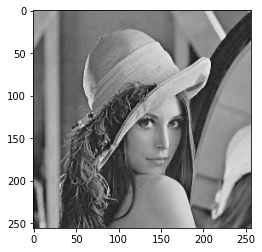

(256, 256)
<class 'numpy.ndarray'>


In [ ]:
from PIL import Image
import cv2
import numpy as np
import sys
from matplotlib import pyplot as plt

np.set_printoptions(threshold=sys.maxsize)
image =cv2.imread("input.png",0)
plt.imshow(image,cmap='gray')
plt.show()
print(image.shape)
print(type(image))
# print(image)

**Divide into 4x4 blocks**

(64, 64, 4, 4)
[[165 161 157 157]
 [163 160 158 159]
 [161 159 158 160]
 [159 158 157 158]]
[[161 163 162 159]
 [162 162 159 155]
 [161 160 155 150]
 [159 158 154 150]]
[[158 156 155 155]
 [158 156 154 153]
 [158 156 155 154]
 [158 157 156 156]]


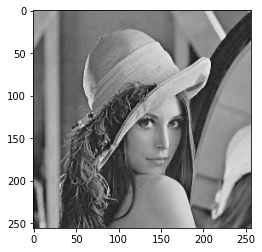

In [ ]:
img_strided = image.reshape(image.shape[0]//4, 4, image.shape[1]//4, 4).swapaxes(1, 2)
print(img_strided.shape)
print(img_strided[0][0])
print(img_strided[0][1])
print(img_strided[1][0])
plt.imshow(image,cmap='gray')
plt.show()

In [ ]:
#initializations

import hashlib
import random

seed = 1
random.seed(seed)

block_l = img_strided.shape[0]
block_w = img_strided.shape[1]
watermarked_image = np.zeros((block_l*4,block_w*4),dtype=int)
NO_OF_BLOCKS=block_l*block_w
BLOCK_KEYS = ['{0:016b}'.format(x) for x in random.sample(range(0, 2**16), NO_OF_BLOCKS)]
BLOCK_KEYS = np.reshape(BLOCK_KEYS,(block_l,block_w))

print(BLOCK_KEYS.shape)
print(BLOCK_KEYS[0][0])

(64, 64)
0100010011001011


In [ ]:
print(BLOCK_KEYS[0,0])

0100010011001011


In [ ]:
def strip_lsb(block):
  stripped_block=np.zeros(block.shape,dtype=int)
  for i in range(4):
    for j in range(4):
      stripped_block[i,j] = block[i,j] & 0xfffe
  return stripped_block

def generate_hashcode16(block):
  block_string = "".join([str(x) for x in block.ravel()])
  key = hashlib.sha1(block_string.encode())
  digest = key.hexdigest()
  binary_16_digest = ''.join(format(ord(i), '08b') for i in digest[:2])
  return binary_16_digest
  

b = img_strided[0][0]
print(b)
b = strip_lsb(b)
print(b)
h = generate_hashcode16(b)
print(h)


[[165 161 157 157]
 [163 160 158 159]
 [161 159 158 160]
 [159 158 157 158]]
[[164 160 156 156]
 [162 160 158 158]
 [160 158 158 160]
 [158 158 156 158]]
0011011100110111


In [ ]:
def generate_hash_key_code(block_key,hash_code):
  x = int(block_key, 2)
  y = int(h, 2)
  z = '{0:016b}'.format(x ^ y)
  return z


hkc = generate_hash_key_code(BLOCK_KEYS[0,0],h)
print("Block key:", BLOCK_KEYS[0,0])
print("Hash Key:", h)
print("Hash Key Code:", hkc)


Block key: 0100010011001011
Hash Key: 0011011100110111
Hash Key Code: 0111001111111100


In [ ]:
def embed(block, hash_key_code):
  embedded_block = block.copy()
  key_mat = np.reshape([int(x) for x in list(hash_key_code)],(4,4))
  # print(key_mat)
  for i in range(4):
    for j in range(4):
      if key_mat[i,j] == 0:
        embedded_block[i,j] = embedded_block[i,j] & 0xfffe
      else:
        embedded_block[i,j] = embedded_block[i,j] | 0x0001
    
  return embedded_block


final_block =  embed(img_strided[0][0],hkc)
print(img_strided[0][0])
print(final_block)


[[165 161 157 157]
 [163 160 158 159]
 [161 159 158 160]
 [159 158 157 158]]
[[164 161 157 157]
 [162 160 159 159]
 [161 159 159 161]
 [159 159 156 158]]


In [ ]:
def get_lsbs(block):
  lsb_array = []
  for i in range(4):
    for j in range(4):
      lsb_array.append(str(block[i,j] & 1))
  return "".join(lsb_array)

#print(get_lsbs(embedded_block[0,0]))

In [ ]:
#Block processing

for i in range(block_l):
  for j in range(block_w):
    block = img_strided[i,j]
    #print(block)
    block_key = BLOCK_KEYS[i,j]
    #print(block_key)
    stripped_block = strip_lsb(block)
    #print(stripped_block)
    hash_code = generate_hashcode16(stripped_block)
    #print(hash_code)
    hash_key_code = generate_hash_key_code(block_key,hash_code)
    #print(hash_key_code)
    watermarked_image[i*4:i*4+4,j*4:j*4+4] |= embed(block,hash_key_code)
    #print(watermarked_image[i*4:i*4+4,j*4:j*4+4])



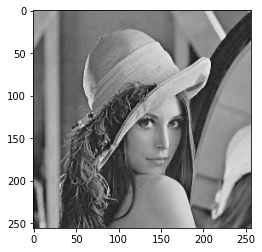

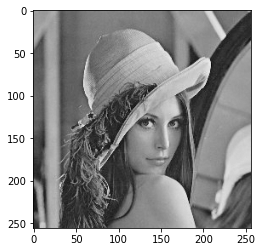

True

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(image,cmap='gray')
plt.show()

plt.imshow(watermarked_image,cmap='gray')
plt.show()

cv2.imwrite("watermarked_image.png",watermarked_image)


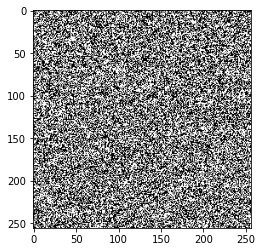

In [ ]:
change = np.abs(image-watermarked_image)*255
plt.imshow(change,cmap='gray')
plt.show()

**PSNR Calculation** 

In [ ]:
import math
import numpy as np

def calculate_psnr(img1, img2):
    # img1 and img2 have range [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))

calculate_psnr(image, watermarked_image)

51.159432177037345

**SSIM Calculation**

In [ ]:
import math
import numpy as np
import cv2

def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

ssim(image, watermarked_image)

0.9977618759856359

**Hashkey Extraction**

In [ ]:

# tamper = np.zeros((256,256))
# positive=int(256*256*rate/100)
# for i in range(positive):
#   tamper[int(np.floor(i/256)),i%256] = 1

# indices = np.random.choice(64*64,size=int(256*256*rate/100),replace=True)
# print(len(indices))
# rows = np.floor(indices/256).astype(int)
# columns = indices%256
# tamper = np.zeros((256,256))
# for i in range(len(rows)):
#   # print(indices[i],rows[i],columns[i])
#   tamper[rows[i],columns[i]] = 1
# tamper
# len(np.unique(indices))

**For Copy paste**

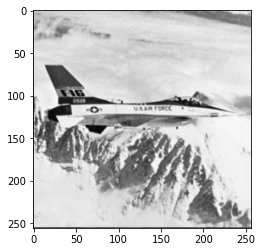

In [ ]:
sample =cv2.imread("airplane.png",0)
plt.imshow(sample,cmap='gray')
plt.show()

Tamper area: (25, 25)
625


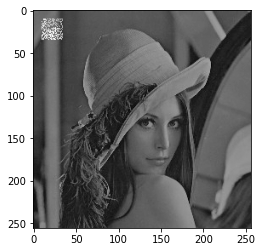

True

In [ ]:
rate=1
tamper = np.zeros((256,256))
x=np.sqrt(rate/100)
tamper_area=(int(watermarked_image.shape[0]*x), int(watermarked_image.shape[1]*x) )
#tuple(int(ti*rate/(100)) for ti in watermarked_image.shape)
# tamper_area=watermarked_image.shape
print("Tamper area:", tamper_area)
# print(type(watermarked_image.shape))

#for random tampering
# tamper[0+10:tamper_area[0]+10,0+10:tamper_area[1]+10] = (np.sign(np.random.uniform(0, 1, size=tamper_area)-0.5)+1)/2

# print(tamper_area[0]+20,2*tamper_area[0]+20,tamper_area[1]+20,2*tamper_area[1]+20)
# print(((np.sign(np.random.uniform(size=tamper_area)-0.5)+1)/2).shape)

#for copy move
# tamper[10:tamper_area[0]+10,10:tamper_area[1]+10] = (watermarked_image[20:tamper_area[0]+20,20:tamper_area[1]+20])*((np.sign(np.random.uniform(size=tamper_area)-0.5)+1)/2)

#for copy paste
tamper[10:tamper_area[0]+10,10:tamper_area[1]+10] = (sample[20:tamper_area[0]+20,20:tamper_area[1]+20])*((np.sign(np.random.uniform(size=tamper_area)-0.5)+1)/2)
true_positives = np.count_nonzero(tamper)
positives=tamper_area[0]*tamper_area[1] #np.count_nonzero(tamper == 1) 
print(positives)
tampered_image = tamper+watermarked_image
plt.imshow(tampered_image,cmap='gray')
plt.show()

cv2.imwrite("tampered_image.png",tampered_image)

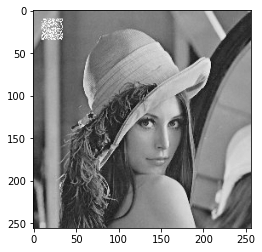

In [ ]:
embd_img =cv2.imread("tampered_image.png",0)
# embd_img =cv2.imread("watermarked_image50.png",0)
plt.imshow(embd_img,cmap='gray')
plt.show()

In [ ]:
#Decoding

embd_strided = embd_img.reshape(embd_img.shape[0]//4, 4, embd_img.shape[1]//4, 4).swapaxes(1, 2)
print(embd_strided.shape)
print(embd_strided[0][0])

(64, 64, 4, 4)
[[164 161 157 157]
 [162 160 159 159]
 [161 159 159 161]
 [159 159 156 158]]


In [ ]:
#initializations
import hashlib
import random

seed = 1
random.seed(seed)
block_l = embd_strided.shape[0]
block_w = embd_strided.shape[1]
NO_OF_BLOCKS=block_l*block_w
EX_BLOCK_KEYS = ['{0:016b}'.format(x) for x in random.sample(range(0, 2**16), NO_OF_BLOCKS)]
EX_BLOCK_KEYS = np.reshape(EX_BLOCK_KEYS,(block_l,block_w))

print(EX_BLOCK_KEYS.shape)
print(EX_BLOCK_KEYS[0][0])

(64, 64)
0100010011001011


Tampered Image 


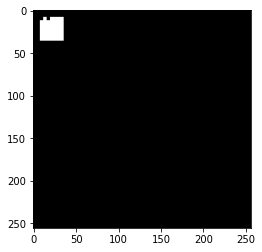

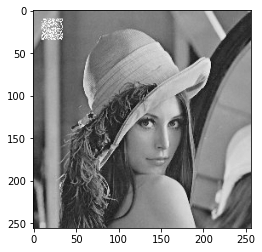

Tampered Pixels: 752
Positive pixels: 625
1
FPR: 20.32
FPR: 0.6943912197066082


In [ ]:
from re import T
tampered = False
count=0
mask=np.zeros((block_l*4, block_w*4), np.int8)
for i in range(block_l):
  for j in range(block_w):
    #print(i,j)
    block = embd_strided[i,j]
    #print(block)
    block_key = EX_BLOCK_KEYS[i,j]
    #print(block_key)
    stripped_block = strip_lsb(block)
    #print(stripped_block)
    hash_code = generate_hashcode16(stripped_block)
    #print(hash_code)
    hash_key_code = generate_hash_key_code(block_key,hash_code)
    water_marked_lsbs = get_lsbs(block)
    #print(hash_key_code==water_marked_lsbs)
    #print(hash_key_code,"<--->",water_marked_lsbs)
    #Checking equality of extracted hash code and computed hashkey code
    if hash_key_code!=water_marked_lsbs :
      #print('###',i,j)
      mask[i*4:i*4+4, j*4:j*4+4]=np.ones((4, 4), np.int8)
      tampered=True
      count+=1

      
if tampered :
  print("Tampered Image ")
  #print(mask)
  plt.imshow(mask,cmap='gray',vmin=0, vmax=1)
  plt.show()
  plt.imshow(embd_img,cmap='gray')
  plt.show()
  tpixels=count*16
  # positive=np.count_nonzero()
  # positive=len(indices)
  a=256*256*50/100
  print("Tampered Pixels:", tpixels)
  print("Positive pixels:",positives)
  print(rate)
  
  #FPR Calculation
  print("FPR:", (tpixels-positives)*100/positives)
  print("FPR:", (tpixels-true_positives)*100/(256*256-true_positives))
  # print("FPR: ", (tpixels-a)*100/a)
else:
  print("Orginal image")
    

320


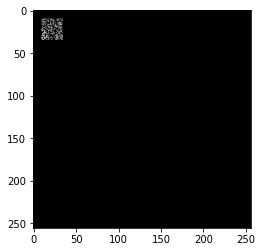

In [ ]:
change = np.abs(watermarked_image-embd_img)*255
print(np.count_nonzero(change))
plt.imshow(change,cmap='gray')
plt.show()

In [ ]:
block

array([[ 61,  78,  83,  95],
       [ 78,  88,  93,  90],
       [ 80,  96, 105,  98],
       [ 93, 104, 104, 108]], dtype=uint8)